<a href="https://colab.research.google.com/github/rijinbaby/Urban-Sound-Classification/blob/main/usc_5050_DNN_all_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing required libraries
#Keras
import tensorflow.keras
from tensorflow.keras import regularizers, layers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

#sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Others
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import tensorflow as tf
import pandas as pd
import seaborn as sns
import glob
import os
import pickle
import IPython.display as ipd
import csv
from tqdm import tqdm
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf_device='/gpu:0'

# **Confusion matrix**

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.rcParams["font.family"] = 'NanumGothic'
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        plt.savefig(title +'.jpg')

# Data Processing

In [ ]:
#split the dataset into train and test

# X_train = pd.read_csv('X_train_5050_all_aug.csv')
X_train = pd.read_csv('https://raw.githubusercontent.com/rijinbaby/Urban-Sound-Classification/main/Datasets/X_train_5050_all_aug.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/rijinbaby/Urban-Sound-Classification/main/Datasets/y_train_5050_all_aug.csv')
X_test = pd.read_csv('https://raw.githubusercontent.com/rijinbaby/Urban-Sound-Classification/main/Datasets/X_test_5050_all_aug.csv')
y_test = pd.read_csv('https://raw.githubusercontent.com/rijinbaby/Urban-Sound-Classification/main/Datasets/y_test_5050_all_aug.csv')
#take a peak at the data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22495, 50), (22495, 1), (4233, 51), (4233, 2))

In [ ]:
X_val =  X_test[X_test['fold_no'] == 5].iloc[:,1:51]
y_val = y_test[y_test['fold_no']==5].iloc[:,0:1]

X_test7 =  X_test[X_test['fold_no'] == 7].iloc[:,1:51]
y_test7 = y_test[y_test['fold_no']==7].iloc[:,0:1]

X_test8 =  X_test[X_test['fold_no'] == 8].iloc[:,1:51]
y_test8 = y_test[y_test['fold_no']==8].iloc[:,0:1]

X_test9 =  X_test[X_test['fold_no'] == 9].iloc[:,1:51]
y_test9 = y_test[y_test['fold_no']==9].iloc[:,0:1]

X_test10 =  X_test[X_test['fold_no'] == 10].iloc[:,1:51]
y_test10 = y_test[y_test['fold_no']==10].iloc[:,0:1]

X_test = X_test.iloc[:,1:51]

In [ ]:
def model_prediction_on_folds(model):
  fold5 = model.evaluate(X_val, y_val)
  fold7 = model.evaluate(X_test7, y_test7)
  fold8 = model.evaluate(X_test8, y_test8)
  fold9 = model.evaluate(X_test9, y_test9)
  fold10 = model.evaluate(X_test10, y_test10)
  fold_accuracy = [fold5[1],fold7[1],fold8[1],fold9[1],fold10[1]]
  return fold_accuracy

In [ ]:
#normalization (helps with exploding gradient); good as we are mixing a lot of datasets
def standardization(data):
  mean = np.mean(data,axis=0)
  std = np.std(data, axis=0)
  data =( data - mean)/std
  data = np.array(data)
  return data

In [ ]:
X_train = standardization(X_train)
X_test = standardization(X_test)
X_val = standardization(X_val)
X_test7 = standardization(X_test7)
X_test8 = standardization(X_test8)
X_test9 = standardization(X_test9)
X_test10 = standardization(X_test10)

In [ ]:
#one hot encoding the target
le = LabelEncoder()

def encoding_y(data):
  data = np.array(data['label'])
  data = to_categorical(le.fit_transform(data))
  return data

In [ ]:
y_train = encoding_y(y_train)
y_test = encoding_y(y_test) 
y_val = encoding_y(y_val)
y_test7 = encoding_y(y_test7)
y_test8 = encoding_y(y_test8)
y_test9 = encoding_y(y_test9)
y_test10 = encoding_y(y_test10)

In [ ]:
#pickel the le object for future use
filename = 'labels_usc'
outfile = open(filename, 'wb')
pickle.dump(le, outfile)
outfile.close()

In [ ]:
from sklearn.decomposition import PCA
pca_item = PCA(n_components=40)
principalComponents_usc = pca_item.fit_transform(X_train)

In [ ]:
principalComponents_usc

array([[-1.72823166, -0.53752949,  0.06650682, ..., -0.35730068,
         0.13942238,  0.19397067],
       [-0.48480878, -0.5787484 , -0.43880975, ..., -0.4185949 ,
        -0.42395524,  0.43822421],
       [-0.5074117 , -0.55164417, -0.25369822, ..., -0.22320867,
        -0.24779659,  0.55666641],
       ...,
       [ 2.18146041, -1.02551514,  0.18002634, ...,  0.07407931,
         0.57762343, -0.38252871],
       [ 1.26246854, -1.22487918,  0.32789384, ..., -0.1034769 ,
         0.46417168, -0.14709716],
       [ 1.89033605, -0.79055919,  0.32128861, ...,  0.10206371,
         0.4163105 , -0.71544744]])

In [ ]:
principal_breast_Df = pd.DataFrame(data = principalComponents_usc)

In [ ]:
principal_breast_Df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
22490,0.344371,-3.168469,6.926214,1.028560,-1.402858,1.927066,2.692931,-1.010651,4.856947,3.689941,-0.657930,3.085427,1.959821,1.714938,1.261622,0.384944,-1.101390,-0.531040,0.418147,1.744688,0.592449,0.692891,-0.816672,0.366110,0.107790,0.642506,0.285455,-0.092844,-0.325202,0.567901,-0.263039,-0.029608,-0.292246,-0.313063,0.669911,0.183388,0.110774,0.182288,0.192108,-0.032862
22491,-2.706833,-1.861259,0.515131,-2.832868,-0.873583,0.997244,4.882682,-2.142961,2.887111,-0.172458,2.161154,2.645670,0.932967,3.852027,-0.553419,0.471948,-0.820363,-0.478532,0.323930,1.407069,-0.476357,-0.258541,0.412975,0.983328,-0.110965,0.709856,0.571259,-0.753504,-0.027004,-0.144000,-1.154041,-0.029935,-0.119630,0.856987,0.466802,-0.660013,0.038827,-0.116831,-0.065102,-0.546170
22492,2.181460,-1.025515,0.180026,-2.513550,-0.138155,1.359959,0.598172,-0.167120,-0.224684,0.289799,0.575218,0.168093,1.267377,1.131469,0.386155,-0.530113,0.075687,-0.075881,0.014905,1.631899,-0.200639,-0.638383,0.559954,0.146395,0.261876,1.011560,0.912359,-0.737726,-0.431533,0.553609,-0.507510,0.385356,-0.050527,-0.478682,0.369728,-0.591093,-0.828034,0.074079,0.577623,-0.382529
22493,1.262469,-1.224879,0.327894,-2.031334,0.247640,1.492483,1.206896,-0.599515,0.132828,0.117113,1.225594,0.566726,0.626118,-0.008229,1.599372,1.435997,0.215186,-0.446886,0.555180,0.993535,0.019445,-0.672530,0.619019,-0.740900,-0.454746,1.794901,-0.094131,-0.708066,-0.723672,0.299119,-0.021858,-0.219214,1.010779,-0.231285,0.132436,-1.014566,-1.118612,-0.103477,0.464172,-0.147097
22494,1.890336,-0.790559,0.321289,-2.291657,0.280498,1.445995,1.018895,0.054660,-0.432375,0.525220,0.402429,0.474927,0.562311,1.249266,-0.112466,-1.141430,0.013244,0.063091,0.039705,2.536475,-0.330091,-0.337759,0.510340,0.063163,1.200622,0.575173,0.712070,-0.684818,-0.326111,0.859737,-0.130237,0.703638,0.253105,-0.611983,-0.342296,-0.404553,-1.148403,0.102064,0.416310,-0.715447


In [ ]:
pca_item.explained_variance_ratio_

array([0.14832205, 0.11290679, 0.07967743, 0.06606565, 0.04688   ,
       0.04282405, 0.03408594, 0.03159611, 0.02891881, 0.02740285,
       0.02453088, 0.02285884, 0.02065749, 0.01831331, 0.01760135,
       0.0169378 , 0.01561838, 0.01511608, 0.01289794, 0.01272372,
       0.01217236, 0.01168635, 0.0109863 , 0.01072025, 0.01029712,
       0.00984805, 0.00976702, 0.0093377 , 0.00905505, 0.00880731,
       0.00875754, 0.00820066, 0.00787401, 0.00769807, 0.00726231,
       0.00690829, 0.00654766, 0.0062994 , 0.00610835, 0.00592608])

In [ ]:
print(pca_item.explained_variance_.sum())

48.51192466392652


# **Modelling**

In [65]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf_device='/gpu:0'

#builing our ANN model

model = Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(layers.Dense(1024, activation='relu', input_shape=(principalComponents_usc.shape[1],)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0, decay=0.0, nesterov=False)
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_rmp = tensorflow.keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 1024)              52224     
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                                 
 dense_24 (Dense)            (None, 128)               32896     
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 10)               

In [66]:
model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])

checkpoint = ModelCheckpoint('up/usc_5050_DNN_all_aug.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')  

model_history = model.fit(X_train, y_train,validation_data=(X_val, y_val), epochs=15, batch_size=32, verbose=2, callbacks=[checkpoint])
# model_history = model.fit(principalComponents_usc, y_train, epochs=5, batch_size=32, verbose=2, callbacks=[checkpoint])

Epoch 1/15

Epoch 00001: val_accuracy improved from -inf to 0.58761, saving model to up/usc_5050_DNN_all_aug.h5
703/703 - 7s - loss: 1.0609 - accuracy: 0.6689 - val_loss: 1.3035 - val_accuracy: 0.5876 - 7s/epoch - 10ms/step
Epoch 2/15

Epoch 00002: val_accuracy improved from 0.58761 to 0.59936, saving model to up/usc_5050_DNN_all_aug.h5
703/703 - 6s - loss: 0.4214 - accuracy: 0.8709 - val_loss: 1.3954 - val_accuracy: 0.5994 - 6s/epoch - 9ms/step
Epoch 3/15

Epoch 00003: val_accuracy did not improve from 0.59936
703/703 - 6s - loss: 0.2561 - accuracy: 0.9240 - val_loss: 1.7087 - val_accuracy: 0.5331 - 6s/epoch - 9ms/step
Epoch 4/15

Epoch 00004: val_accuracy did not improve from 0.59936
703/703 - 6s - loss: 0.1668 - accuracy: 0.9524 - val_loss: 1.7683 - val_accuracy: 0.5459 - 6s/epoch - 9ms/step
Epoch 5/15

Epoch 00005: val_accuracy did not improve from 0.59936
703/703 - 6s - loss: 0.1181 - accuracy: 0.9660 - val_loss: 2.0589 - val_accuracy: 0.5331 - 6s/epoch - 9ms/step
Epoch 6/15

Epoc

<function matplotlib.pyplot.show>

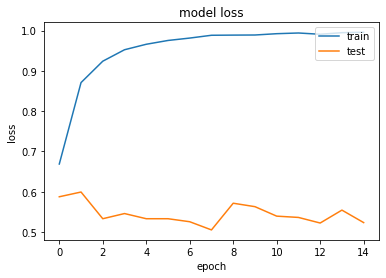

In [67]:
#plotting the loss
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show

# Model Serialisation (saving the model)

In [68]:
#save model to disk 
model_json = model.to_json()
with open('up/usc_5050_DNN_all_aug.json','w') as json_file:
    json_file.write(model_json)

# **Model Validation**

In [69]:
#loading the json file and model architecture
json_file = open('up/usc_5050_DNN_all_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

#load weights into the new mode
loaded_model.load_weights('up/usc_5050_DNN_all_aug.h5')
print('Loaded model from disk')

loaded_model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics =['accuracy'])

score = loaded_model.evaluate(X_test, y_test)
print("%s: %.2f%%" %(loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
133/133 [==============================] - 1s 3ms/step - loss: 1.4178 - accuracy: 0.5941
accuracy: 59.41%


In [70]:
score_avg = model_prediction_on_folds(loaded_model)

27/27 [==============================] - 0s 3ms/step - loss: 1.2435 - accuracy: 0.6129


In [71]:
print((np.mean(score_avg), np.std(score_avg)))

(0.6015297770500183, 0.045060174116835154)


In [72]:
preds = loaded_model.predict(X_test, batch_size=1, verbose=1)
preds = preds.argmax(axis=1)
preds

4233/4233 [==============================] - 5s 1ms/step


array([3, 2, 2, ..., 1, 1, 1])

In [73]:
#The prediction is in the form of numbers, we'll need to append the labels to it before we run the accuracy measure

#predictions
#preds = preds.astype(int).flatten()
preds = le.inverse_transform(preds)
preds= pd.DataFrame({'predicted_values': preds})

#Actual labels

actual = y_test.argmax(axis=1)
#actual = actual.astype(int).flatten()
actual = le.inverse_transform(actual)
actual = pd.DataFrame({'actual_values': actual})

#combine both in one dataframe
final_df = actual.join(preds)
final_df.head()

,actual_values,predicted_values
0,3,3
1,2,2
2,2,2
3,2,2
4,2,2


[]

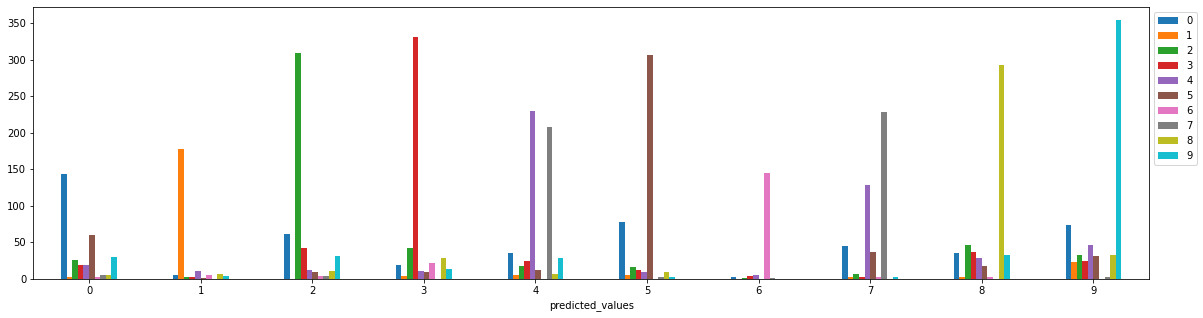

In [74]:
#write out predictions to disk
#final_df.to_csv('usc_pred.csv', index=False)
ddf = final_df.groupby('predicted_values')['actual_values'].value_counts()
#final_df.groupby('actual_values').count()

ax = ddf.unstack().plot(kind='bar',figsize=(20,5), rot = 0)
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

In [75]:
#Classification report
classes = final_df.actual_values.unique()
classes.sort()
print(classification_report(final_df.actual_values, final_df.predicted_values))

              precision    recall  f1-score   support

           0       0.46      0.29      0.35       500
           1       0.82      0.80      0.81       221
           2       0.64      0.62      0.63       500
           3       0.69      0.66      0.68       500
           4       0.40      0.46      0.43       500
           5       0.69      0.63      0.66       483
           6       0.91      0.79      0.85       184
           7       0.50      0.50      0.50       452
           8       0.59      0.75      0.66       393
           9       0.57      0.71      0.63       500

    accuracy                           0.59      4233
   macro avg       0.63      0.62      0.62      4233
weighted avg       0.60      0.59      0.59      4233



In [76]:
k_df = final_df.copy()
k_df = k_df.astype(str)
k_df['actual_values'] = k_df.actual_values.replace({          
                                        '0.0' :   'air_conditioner',
                                        '1.0' :  'car_horn',
                                        '2.0' :  'children_playing',
                                        '3.0' :  'dog_bark' ,      
                                        '4.0' :  'drilling',       
                                        '5.0' :  'engine_idling',  
                                        '6.0' :  'gun_shot',
                                        '7.0' :  'jackhammer',     
                                        '8.0' :  'siren', 
                                        '9.0' :  'street_music'
                                                         })
k_df['predicted_values'] = k_df.predicted_values.replace({
                                        '0.0' :   'air_conditioner',
                                        '1.0' :  'car_horn',
                                        '2.0' :  'children_playing',
                                        '3.0' :  'dog_bark' ,      
                                        '4.0' :  'drilling',       
                                        '5.0' :  'engine_idling',  
                                        '6.0' :  'gun_shot',
                                        '7.0' :  'jackhammer',     
                                        '8.0' :  'siren', 
                                        '9.0' :  'street_music'
                                                         })


classes = k_df.actual_values.unique()
classes.sort()

In [77]:
#k_df = k_df.astype(str)
k_df.actual_values.value_counts()

4    500
9    500
0    500
2    500
3    500
5    483
7    452
8    393
1    221
6    184
Name: actual_values, dtype: int64

0.5941412709662178


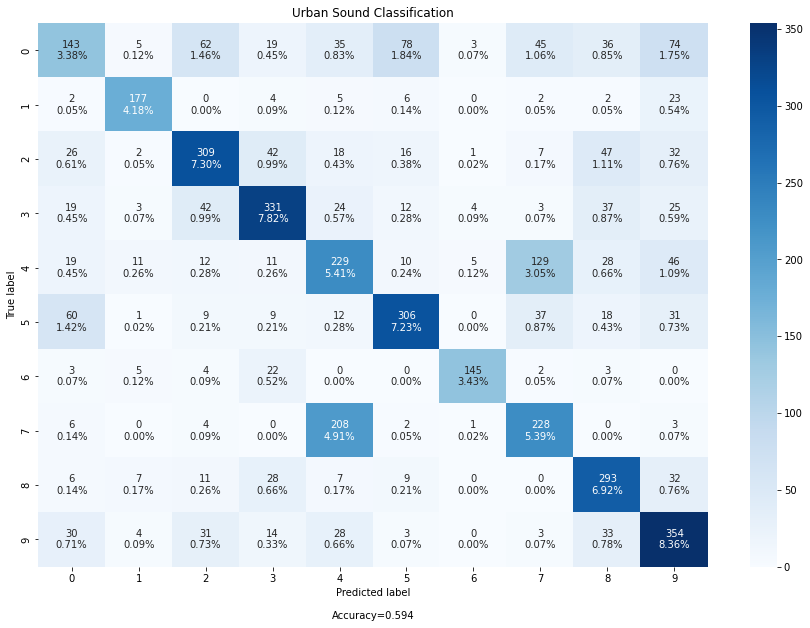

In [78]:
#final_df = pd.read_csv("kr_13_p.csv")
classes = k_df.actual_values.unique()
classes.sort()

#confusion matrix
c = confusion_matrix(k_df.actual_values, k_df.predicted_values)
print(accuracy_score(k_df.actual_values, k_df.predicted_values))
make_confusion_matrix(c, group_names=['True Values','Predicted Value'], categories=classes, figsize =(15,10), title='Urban Sound Classification')